Initial Implementation of GP

Inspired by: https://peterroelants.github.io/posts/gaussian-process-tutorial/



In [359]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

# Set matplotlib and seaborn plotting style
sns.set_style('darkgrid')
np.random.seed(42)

In [360]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from Models.BNN import BayesianNetwork
from data import Dataprep, update_data, load_data
import argparse
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import datetime
import torch

In [370]:
dataset_type='Generated_2000'
sensor='foundation_origin xy FloaterOffset [m]'
samples_per_step=100
validation_size=0.1

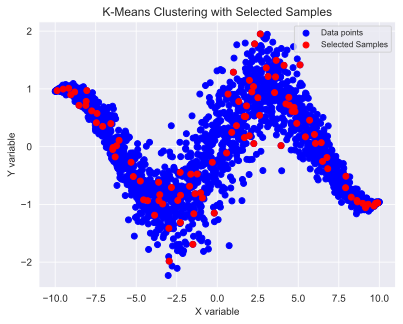

In [371]:
data = Dataprep(dataset_type, sensor, initial_samplesize=samples_per_step)
known_data, pool_data = data.known_data, data.pool_data

Load Data and Normalize

In [372]:
train, val = train_test_split(known_data, test_size=validation_size)

x_min = np.min(train[:, 0])
x_max = np.max(train[:, 0])
y_min = np.min(train[:, 1])
y_max = np.max(train[:, 1])
print("Before normalization")
print("x value range:", x_min, "-", x_max)
print("y value range:", y_min, "-", y_max)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_1 = scaler.fit_transform(train[:, 0].reshape(-1, 1))
y_1 = train[:, 1]


x_min = np.min(X_1)
x_max = np.max(X_1)
y_min = np.min(y_1)
y_max = np.max(y_1)

print("\nAfter normalization")
print("x value range:", x_min, "-", x_max)
print("y value range:", y_min, "-", y_max)

Before normalization
x value range: -9.87994 - 9.89995
y value range: -1.9830012 - 1.9509175

After normalization
x value range: 0.0 - 1.0
y value range: -1.9830012 - 1.9509175


In [386]:
# Define the RBF KERNEL serving as covariance function (Other KERNELS can be used as well)
def rbf_kernel(x_a, x_b):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(x_a, x_b, 'sqeuclidean')
    return np.exp(sq_norm)

# Gaussian process posterior
def GP(X1, y1, X2, kernel_func, σ_noise=1e-3):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the noisy observations 
    (y1, X1), and the prior kernel function.
    """
    # Kernel of the noisy observations
    Σ11 = kernel_func(X1, X1) + ((σ_noise ** 2) * np.eye(X_1.shape[0]))
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2) 
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [387]:
# Compute the posterior mean and covariance
n2 = 10  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (x_min, x_max)


# Predict points at uniform spacing to capture function
X_2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)
# Compute posterior mean and covariance
μ2, Σ2 = GP(X_1, y_1, X_2, rbf_kernel)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y_2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

In [388]:
X_1.shape

(90, 1)

In [389]:
print(X_1.shape)
print(X_2.shape)
print(y_2.shape)
print(y_1.shape)

(90, 1)
(10, 1)
(5, 10)
(90,)


/var/folders/bx/yqrc6c_d2z34yz6mbn3s8b980000gn/T/ipykernel_74687/294566982.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(scaler.fit_transform(pool_data[:,0].reshape(-1,1)), pool_data[:,1], 'ko', linewidth=2, label='$(x_1, y_1)$', color='lightgrey', alpha=0.2)


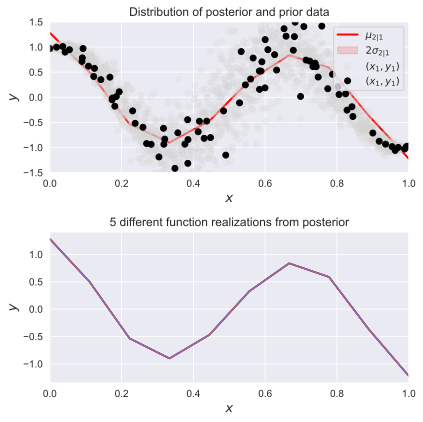

In [399]:
z = np.mean(y_2, axis=0)

# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X_2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.fill_between(X_2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2\sigma_{2|1}$')
ax1.plot(scaler.fit_transform(pool_data[:,0].reshape(-1,1)), pool_data[:,1], 'ko', linewidth=2, label='$(x_1, y_1)$', color='lightgrey', alpha=0.2)
ax1.plot(X_1, y_1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X_2, y_2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title(f'{ny} different function realizations from posterior')
ax1.axis([domain[0], domain[1], -1.5, 1.5])
ax2.set_xlim([domain[0], domain[1]])
plt.tight_layout()
plt.show()